# `MEDUSA`
aka. Dynamic-Prospective LCA aka. Union(premise, temporalis)

In [1]:
from bw_temporalis import easy_timedelta_distribution, TemporalDistribution, easy_datetime_distribution
#from bw_temporalis.lcia.climate import characterize_methane, characterize_co2
import sys
import os
sys.path.append(os.path.realpath('../'))
from medusa.edge_extractor import *
from medusa.matrix_modifier import MatrixModifier
from medusa.medusa_lca import *
from medusa.timeline_builder import TimelineBuilder
from medusa.dynamic_characterization import DynamicCharacterization
import bw2data as bd
import bw2calc as bc
import numpy as np
import pandas as pd

In [2]:
from tests.databases import *
db_dynamic_cf_test()

100%|██████████| 4/4 [00:00<?, ?it/s]

Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 3998.38it/s]


Vacuuming database 


In [3]:
demand = {('foreground', 'A'): 1}
gwp = ('GWP', 'example')

# Static LCA

In [4]:
slca = bc.LCA(demand, gwp)
slca.lci()
slca.lcia()
print(f'Static LCA score: {slca.score}')

Static LCA score: 901.0


# `MEDUSA` LCA

In [5]:
SKIPPABLE = [node.id for node in bd.Database('background_2020')] + [
    node.id for node in bd.Database('background_2024')
]

def filter_function(database_id: int) -> bool:
    return database_id in SKIPPABLE

Now we can do the graph traversal and create a timeline of edges:

In [6]:
import warnings
warnings.filterwarnings("ignore")

database_date_dict = {
            'background_2008': datetime.strptime("2008", "%Y"),
            'background_2024': datetime.strptime("2024", "%Y"),
            'foreground': "dynamic", # flag databases that should be temporally distributed with "dynamic"
        }

In [7]:
mlca = MedusaLCA(demand, gwp, filter_function, database_date_dict, max_calc=1000)

Starting graph traversal
Calculation count: 3


In [8]:
mlca.build_timeline()

All databases in database_date_dict exist as brightway project databases


,hash_producer,time_mapped_producer,date_producer,producer,producer_name,hash_consumer,time_mapped_consumer,date_consumer,consumer,consumer_name,amount,interpolation_weights
0,1999,945,1999-01-01,939,C,1999,946,1999-01-01,943,B,13.0,{'background_2008': 1}
1,1999,946,1999-01-01,943,B,2024,948,2024-01-01,944,A,2.0,{'background_2008': 1}
2,2024,939,2024-01-01,939,C,2024,947,2024-01-01,943,B,13.0,{'background_2024': 1}
3,2024,947,2024-01-01,943,B,2024,948,2024-01-01,944,A,0.8,{'background_2024': 1}
4,2024,948,2024-01-01,944,A,2024,-1,2024-01-01,-1,-1,1.0,{'background_2024': 1}
5,2034,949,2034-01-01,943,B,2024,948,2024-01-01,944,A,1.2,{'background_2024': 1}
6,2034,950,2034-01-01,939,C,2034,949,2034-01-01,943,B,13.0,{'background_2024': 1}


In [9]:
mlca.build_datapackage()

In [10]:
mlca.lci()

In [11]:
mlca.lcia()

In [12]:
print('New MEDUSA LCA Score:', mlca.score)
print('Old static LCA Score:', slca.score)

New MEDUSA LCA Score: 901.0
Old static LCA Score: 901.0


In [13]:
mlca.build_dynamic_biosphere()

In [14]:
mlca.calculate_dynamic_lci()


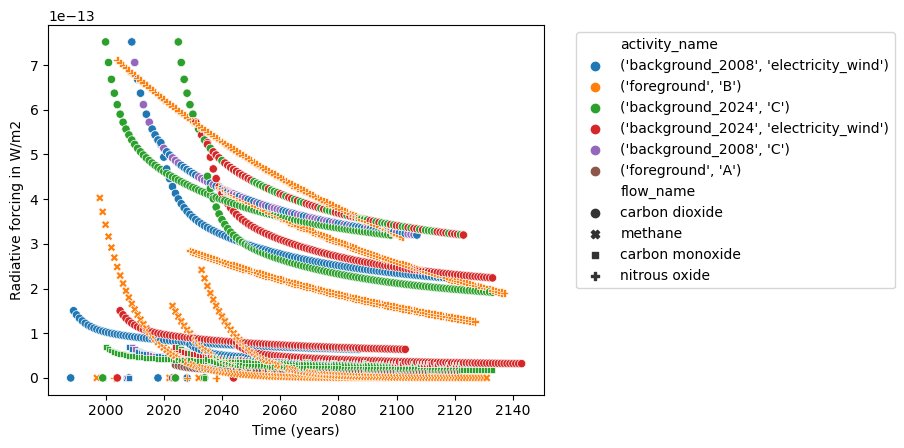

In [15]:
mlca.characterize_dynamic_lci(type="radiative_forcing")
mlca.plot_dynamic_characterized_inventory()


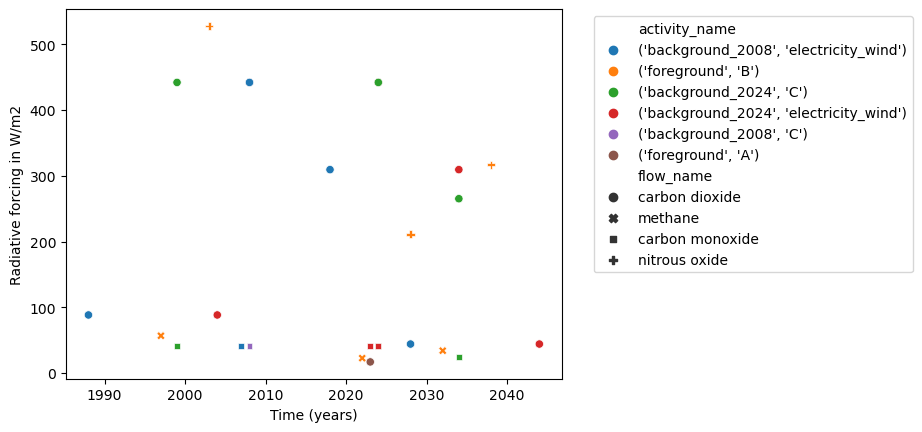

In [16]:
mlca.characterize_dynamic_lci(type="GWP")
mlca.plot_dynamic_characterized_inventory()

#todo think about storing and plotting radiative forcing and GWP seperately

In [17]:
mlca.dynamic_inventory_characterizer.levasseur_dcfs.keys() 
# available dynamic characterization factors for GHGs, only first 4 ones are currently used but all would be there

dict_keys(['carbon dioxide', 'methane', 'nitrous oxide', 'carbon monoxide', 'CFC-11', 'CFC-12', 'CFC-13', 'CFC-113', 'CFC-114', 'CFC-115', 'Halon-1201', 'Halon-1202', 'Halon-1211', 'Halon-1301', 'Halon-2301', 'Halon-2311', 'Halon-2401', 'Halon-2402', 'Carbon tetrachloride (CFC-10)', 'Methyl bromide (Halon 1001)', 'Methylene bromide', 'Methyl chloroform (trichloroethane)', '1,2-dichloroethane', 'Chloroform', 'HCFC-21', 'HCFC-22', 'HCFC-122', 'HCFC-122a', 'HCFC-123', 'HCFC-124', 'HCFC-132c', 'HCFC-141b', 'HCFC-142b', 'HCFC-225ca', 'HCFC-225cb', 'E-1-chloro-3,3,3-trifluoroprop-1-ene', 'HFC-23', 'HFC-32', 'HFC-41', 'HFC-125', 'HFC-134', 'HFC-134a', 'HFC-143', 'HFC-143a', 'HFC-152', 'HFC-152a', 'HFC-161', 'HFC-227ca', 'HFC-227ea', 'HFC-236cb', 'HFC-236ea', 'HFC-236fa (HCFC-236fa)', 'HFC-245ca', 'HFC-245cb', 'HFC-245ea', 'HFC-245eb', 'HFC-245fa', 'HFC-272ca', 'HFC-365mfc', 'HFC-43-10mee', 'HFC-1132a', 'HFC-1141', 'Z-HFC-1225ye', 'E-HFC-1225ye', 'Z-HFC-1234ze', 'HFC-1234yf', 'E-HFC-1234ze', '

In [18]:
# old code
#mlca.dynamic_inventory_characterizer.dynamic_characterization_from_giuseppe_levasseur(mlca.characterized_inventory,cumulative=False )

Last progress dynamic cf:
only levassuer dynamic TH is missing. implementation via Levasseur, not Giuseppe's old code

TODO add fixed TH and checks.